<a href="https://colab.research.google.com/github/lexiconlp/transformer-under-the-hood/blob/chore%2Fjupyters-notebooks/3_transformers_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Utils 🔨🪛🔩🔧

In [ ]:
!pip install num2words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 KB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=aa09baeceaa8855098bb7c516a3958e8b67e5396cae0130b96bbeb528f861304
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.autograd import Variable
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam


Clone transfomer under the hood

In [ ]:
!git clone https://github.com/lexiconlp/transformer-under-the-hood.git

Cloning into 'transformer-under-the-hood'...
remote: Enumerating objects: 221, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 221 (delta 12), reused 28 (delta 8), pack-reused 150
Receiving objects: 100% (221/221), 160.47 MiB | 25.58 MiB/s, done.
Resolving deltas: 100% (117/117), done.


In [ ]:
cd transformer-under-the-hood/

/content/transformer-under-the-hood


In [ ]:
!git checkout chore/add-model-bin

Branch 'chore/add-model-bin' set up to track remote branch 'chore/add-model-bin' from 'origin'.
Switched to a new branch 'chore/add-model-bin'


In [ ]:
from transformer_uth.attention_models import AttentionModel, SelfAttentionModel, PositionalAttentionModel
from transformer_uth.vectorizer import CharVectorizer, _text_to_one_hot
from transformer_uth.consts import PATH_TRAIN_DATA
from torch.utils.data import DataLoader
from transformer_uth.train import _save_model, _train_model


In [ ]:
%%time
!python -m transformer_uth.dataset_generator

CPU times: user 240 ms, sys: 35.2 ms, total: 275 ms
Wall time: 25.1 s


#1.  Simple attention mechanism 

(remind **information is represented as a vector**)

Key concept -> Cosine similarity

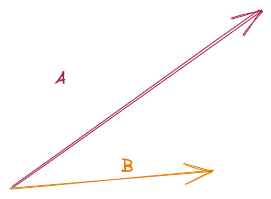

$$\text{cosine similarity} = \frac{\text{A} \cdot \text{B}}{\left|\text{A}\right|_2 \left|\text{B}\right|_2} \in [-1, 1]$$



Attention mechanism is inspired from search 

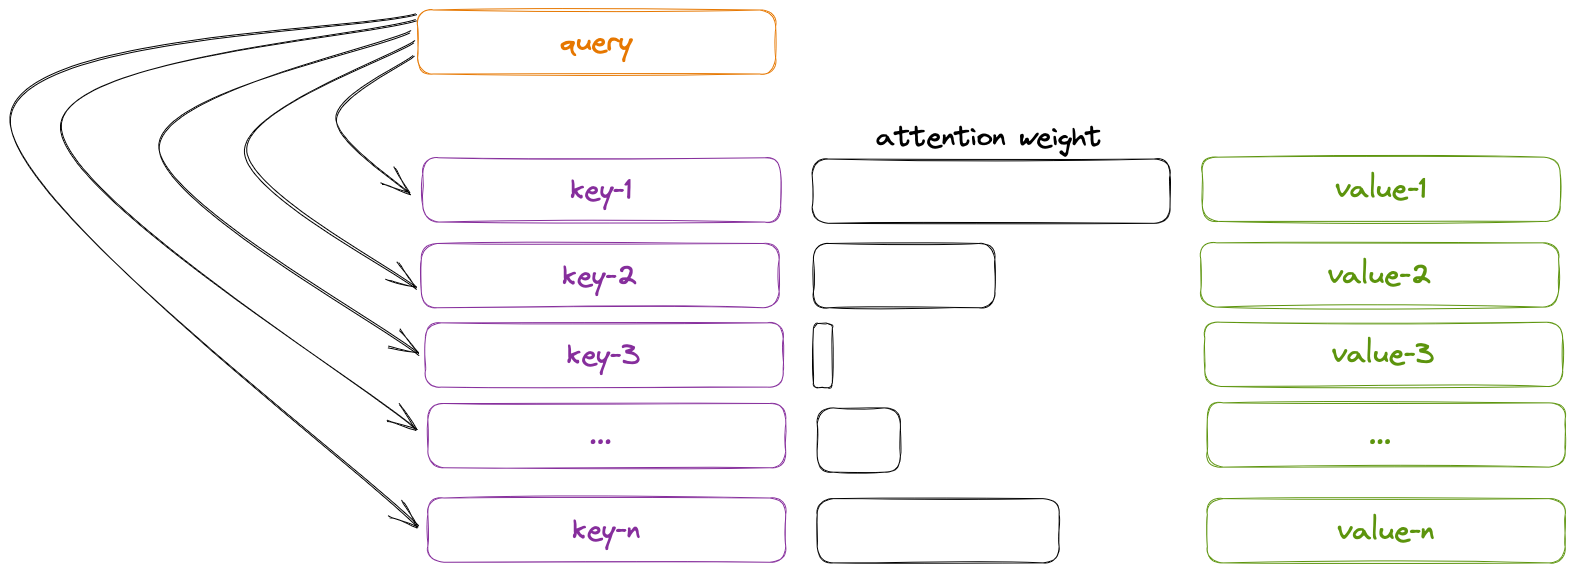

With Attention model, let see a simple sequence problem. (Inspired from [this](https://github.com/greentfrapp/attention-primer/tree/master/1_counting-letters) amazing repo 😍😍)

## Task1 (count letters)

In [ ]:
!head -n 5 transformer_uth/train-data/task1-data.tsv

AADBDACA	4112
ADADADBBD	3204
CDAACCABB	3231
CACBCBCCB	1350
BDCBACD	1222


The goal is from an input matrix $[X]$ convert to matrix $[Y]$ :

$$ [X]_{l_{i}, v_{i}} → [Y]_{l_{o},v_{o}} $$

Where subindex means:

${l} → lenght $

${v} → vocabulary $

$_{i} → input $

$_{o} → output $

So:

${l}_{i} → lenght-input $

${v}_{i} → vocabulary-input $

... etc

A simple attention mechanism in equation can be written as:

## 1.1 Define attention model flow

$\color{blue}{[E]_{l_i,h}} = [X][W_E^{T}]_{v_{i}, h} + [b_E]_{1, h
}$

$\color{purple}{[K]_{l_i,h}} = \color{green}{[V]_{l_i,h}} = \color{blue}{[E]}$

$ [AttentionWeights]_{n_q,l_i} = Softmax\big(\frac{\color{orange}{[Q]_{n_q,h}}\color{purple}{[K^T]}}{\sqrt{{d_{\color{purple}K}}}}\big) $

$[D]_{n_q,h} = [AttentionWeights]\color{green}{[V]} + \color{orange}{[Q]}$

$[D] = LayerNorm([D])$

$ [Y] = [D][W_O^T]_{h,v_{o}} + [b_O]_{1,v_o}$


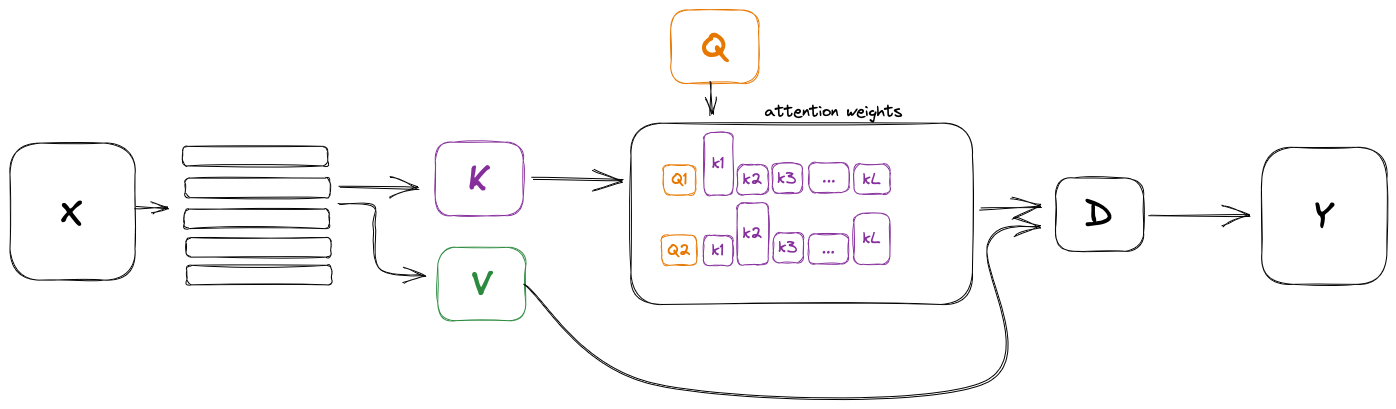

$$ [Y]_{l_{o},v_{o}} $$ 
$$  [[D][W_O^T]_{h,v_{o}}]_{\color{red}{n_q,v_o}}$$

$$n_q == l_o$$

The symbol $[-] $ means is a matrix and sub_index are the dimension of the matrix ( note that the first time a matrix appears have sub_index, the nexts occurences don't have sub-index because is the same matrix )

Nice, but where is the code ??

## 1.2 Load model

In [ ]:
dataset = CharVectorizer(PATH_TRAIN_DATA / "task1-data.tsv")
data_loader = DataLoader(dataset=dataset)

model_att = AttentionModel(dataset.seq_data)

Untrained model...

In [ ]:
model_att.eval()
sample = "ABCAA"
vocab = dataset.input_vocab

vector_sample = _text_to_one_hot(sample, vocab, 9).unsqueeze(0)
logits, attention = model_att(vector_sample)

In [ ]:
pd.DataFrame(attention.detach().numpy().squeeze())

,0,1,2,3,4,5,6,7,8
0,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111
1,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111
2,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111
3,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111


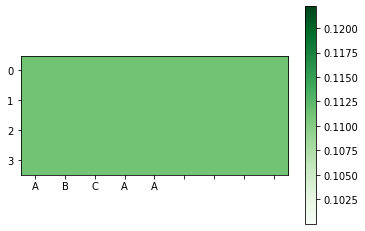

In [ ]:
plt.imshow(attention.detach().numpy().squeeze(), cmap='Greens')
plt.colorbar()
plt.xticks(range(9), list(sample) + [' ' for i in range(len(sample),9)])
plt.show()

## 1.3 Train model 🚂...

In [ ]:
%%time
torch.manual_seed(0)
name_task = "task1"
path_data =  PATH_TRAIN_DATA / f"{name_task}-data.tsv"
model_att_trained = _train_model(path_data,AttentionModel, 5)
_save_model(model_att_trained, f"{name_task}-model.pth")

Starting training model with 1354 parameters
Model description: 
AttentionModel(
  (key_val_dense): Linear(in_features=4, out_features=64, bias=True)
  (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (final_dense): Linear(in_features=64, out_features=10, bias=True)
)
Model parameters: 
query: 256
key_val_dense.weight: 256
key_val_dense.bias: 64
layer_norm.weight: 64
layer_norm.bias: 64
final_dense.weight: 640
final_dense.bias: 10
Iteration 1 - Loss 0.17669175565242767
Iteration 2 - Loss 0.09533992409706116
Iteration 3 - Loss 0.06036529317498207
Iteration 4 - Loss 0.045183293521404266
Iteration 5 - Loss 0.030446326360106468
Training complete!
Model stored in /content/transformer-under-the-hood/transformer_uth/models/task1-model.pth 
CPU times: user 1min 53s, sys: 322 ms, total: 1min 53s
Wall time: 1min 55s


## 1.4 Inference 🧪...

In [ ]:
from transformer_uth.vectorizer import _text_to_one_hot


vectorizer = CharVectorizer(path_data)

model_att_trained.eval()
sample = "ABC"

vector_sample = _text_to_one_hot(sample, vectorizer.input_vocab, 9).unsqueeze(0)
logits, attention = model_att_trained(vector_sample)

In [ ]:
pd.DataFrame(attention.detach().numpy().squeeze())

,0,1,2,3,4,5,6,7,8
0,0.275964,0.066164,0.067075,0.098466,0.098466,0.098466,0.098466,0.098466,0.098466
1,0.069029,0.276748,0.065521,0.098117,0.098117,0.098117,0.098117,0.098117,0.098117
2,0.072249,0.066669,0.270870,0.098369,0.098369,0.098369,0.098369,0.098369,0.098369
3,0.087346,0.085039,0.084084,0.123922,0.123922,0.123922,0.123922,0.123922,0.123922


## 1.5  Visualize attention 🦄 ...

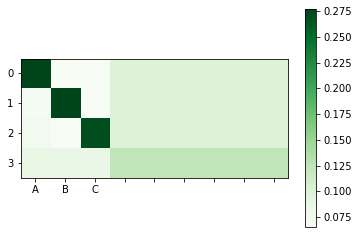

In [ ]:
# create a heatmap of the matrix
plt.imshow(attention.detach().numpy().squeeze(), cmap='Greens')
plt.colorbar()
plt.xticks(range(9), list(sample) + [' ' for i in range(len(sample),9)])
plt.show()

In [ ]:
logits.argmax(-1), logits.shape

(tensor([[1, 1, 1, 0]]), torch.Size([1, 4, 10]))

#2. Self Attention

Let's try a bit difficult problem...

## 2.1. Task ( difference )

In [ ]:
!tail -n 5 transformer_uth/train-data/task2-data.tsv

BAABBDDCA	33120
DADBDDCAD	21151
AABBDCDAD	32131
CDABAADAD	41133
BDABBDBBC	15124


🚂 Train model with only one attetion block...

## 2.2 Train model 🚂 with **attetion block** ...

In [ ]:
%%time
torch.manual_seed(0)
name_task = "task2"
path_data =  PATH_TRAIN_DATA / f"{name_task}-data.tsv"
model_att_trained_task2 = _train_model(path_data,AttentionModel)
_save_model(model_att_trained_task2, f"{name_task}-only-att-model.pth")

Starting training model with 1418 parameters
Model description: 
AttentionModel(
  (key_val_dense): Linear(in_features=4, out_features=64, bias=True)
  (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (final_dense): Linear(in_features=64, out_features=10, bias=True)
)
Model parameters: 
query: 320
key_val_dense.weight: 256
key_val_dense.bias: 64
layer_norm.weight: 64
layer_norm.bias: 64
final_dense.weight: 640
final_dense.bias: 10
Iteration 1 - Loss 0.2640005648136139
Iteration 2 - Loss 0.17805594205856323
Iteration 3 - Loss 0.14304545521736145
Training complete!
Model stored in /content/transformer-under-the-hood/transformer_uth/models/task2-only-att-model.pth 
CPU times: user 1min 13s, sys: 216 ms, total: 1min 13s
Wall time: 1min 13s


## 2.3 Train model 🚂 with **self-attention block** + **attetion block** ...

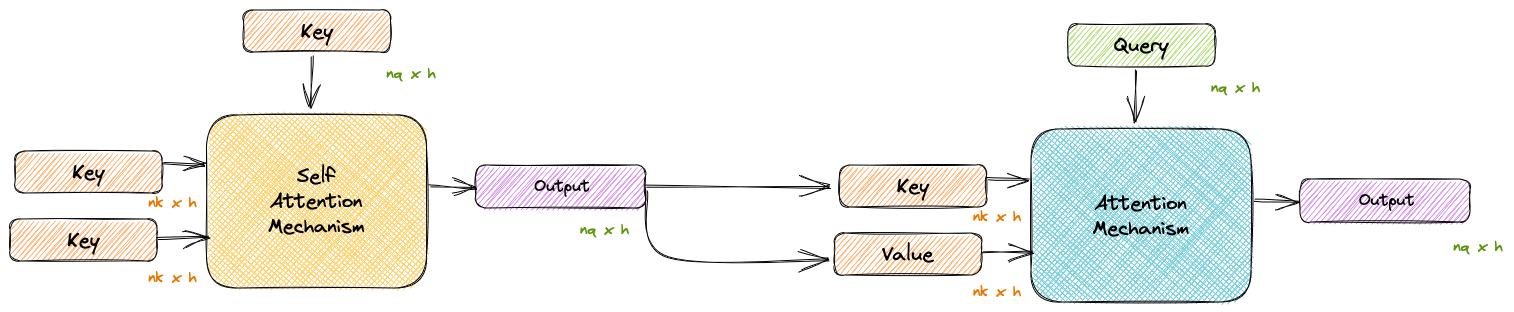

In [ ]:
%%time
torch.manual_seed(0)
name_task = "task2"
path_data =  PATH_TRAIN_DATA / f"{name_task}-data.tsv"
model_self_att_trained = _train_model(path_data,SelfAttentionModel,5)
_save_model(model_self_att_trained, f"{name_task}-model.pth")

Starting training model with 1546 parameters
Model description: 
SelfAttentionModel(
  (key_val_dense): Linear(in_features=4, out_features=64, bias=True)
  (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (layer_norm_self): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (final_dense): Linear(in_features=64, out_features=10, bias=True)
)
Model parameters: 
query: 320
key_val_dense.weight: 256
key_val_dense.bias: 64
layer_norm.weight: 64
layer_norm.bias: 64
layer_norm_self.weight: 64
layer_norm_self.bias: 64
final_dense.weight: 640
final_dense.bias: 10
Iteration 1 - Loss 0.09046532213687897
Iteration 2 - Loss 0.06274398416280746
Iteration 3 - Loss 0.03371578827500343
Iteration 4 - Loss 0.0380055233836174
Epoch 04425: reducing learning rate of group 0 to 1.0000e-03.
Iteration 5 - Loss 0.018284572288393974
Training complete!
Model stored in /content/transformer-under-the-hood/transformer_uth/models/task2-model.pth 
CPU times: user 2min 12s, sys: 338 ms, total: 2

## 2.4 Inference self-attention + attention 🧪 ...

In [ ]:
vectorizer = CharVectorizer(path_data)

model_att_trained.eval()
sample = "ABCAAADDD"

vector_sample = _text_to_one_hot(sample, vectorizer.input_vocab, 9).unsqueeze(0)
logits, attention,self_att = model_self_att_trained(vector_sample)

In [ ]:
pd.DataFrame(attention.detach().numpy().squeeze())

,0,1,2,3,4,5,6,7,8
0,0.187068,0.031926,0.052042,0.187068,0.187068,0.187068,0.055921,0.055921,0.055921
1,0.062016,0.344545,0.105834,0.062016,0.062016,0.062016,0.100518,0.100518,0.100518
2,0.061031,0.058517,0.385191,0.061031,0.061031,0.061031,0.104056,0.104056,0.104056
3,0.040534,0.035717,0.063849,0.040534,0.040534,0.040534,0.246099,0.246099,0.246099
4,0.165522,0.155814,0.044672,0.165522,0.165522,0.165522,0.045808,0.045808,0.045808


## 2.5 Visualize attention 🦄

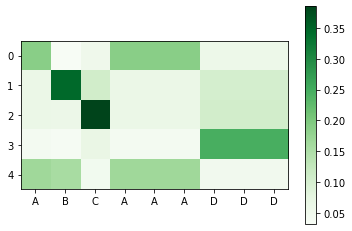

In [ ]:
plt.imshow(attention.detach().numpy().squeeze(), cmap='Greens')
plt.colorbar()
plt.xticks(range(9), list(sample) + [' ' for i in range(len(sample),9)])
plt.show()

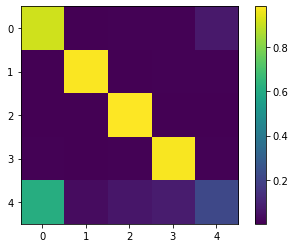

In [ ]:
plt.imshow(self_att.detach().numpy().squeeze())
plt.colorbar()
plt.show()

In [ ]:
logits.argmax(-1), logits.shape

(tensor([[4, 1, 1, 3, 3]]), torch.Size([1, 5, 10]))

## 3. Positional Encoding

Let's try a bit difficult problem...

## 3.1 Task (signal)

In [ ]:
!tail -n 5 transformer_uth/train-data/task3-data.tsv

BAABBDDCA	2
DADBDDCAD	4
AABBDCDAD	2
CDABAADAD	0
BDABBDBBC	4


## 3.2 Train model 🚂 with **attetion block** ...

In [ ]:
%%time
torch.manual_seed(0)
name_task = "task3"
path_data =  PATH_TRAIN_DATA / f"{name_task}-data.tsv"
model_att_trained = _train_model(path_data,AttentionModel)
_save_model(model_att_trained, f"{name_task}-only-att-model.pth")

Starting training model with 1097 parameters
Model description: 
AttentionModel(
  (key_val_dense): Linear(in_features=4, out_features=64, bias=True)
  (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (final_dense): Linear(in_features=64, out_features=9, bias=True)
)
Model parameters: 
query: 64
key_val_dense.weight: 256
key_val_dense.bias: 64
layer_norm.weight: 64
layer_norm.bias: 64
final_dense.weight: 576
final_dense.bias: 9
Iteration 1 - Loss 1.309836506843567
Iteration 2 - Loss 1.288809061050415
Iteration 3 - Loss 1.2697486877441406
Training complete!
Model stored in /content/transformer-under-the-hood/transformer_uth/models/task3-only-att-model.pth 
CPU times: user 53 s, sys: 147 ms, total: 53.2 s
Wall time: 53.5 s


## 3.3 Train model 🚂 with **positional-encoding** + **self-attention block** + **attetion block**...

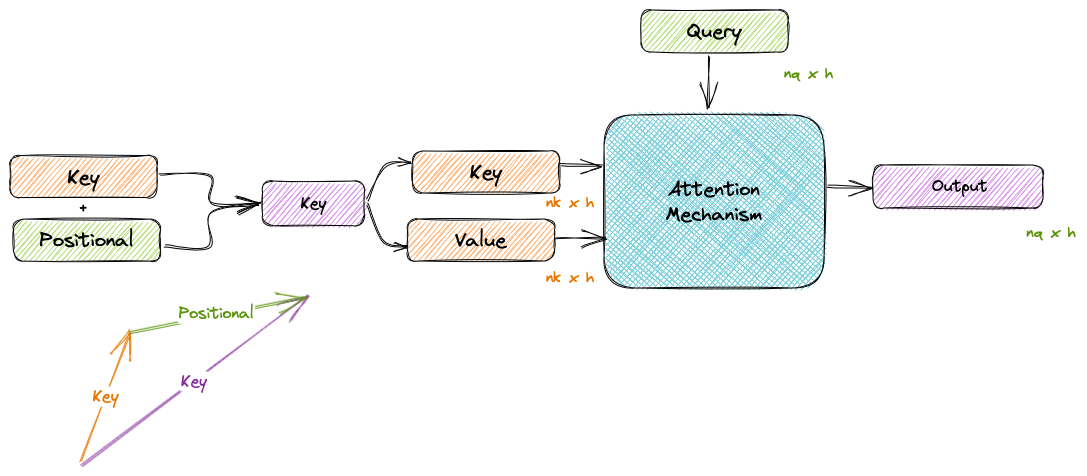

In [ ]:
%%time
torch.manual_seed(2)
name_task = "task3"
path_data =  PATH_TRAIN_DATA / f"{name_task}-data.tsv"
model_pos_trained = _train_model(path_data,PositionalAttentionModel,8)
_save_model(model_pos_trained, f"{name_task}-model.pth")


Starting training model with 1801 parameters
Model description: 
PositionalAttentionModel(
  (key_val_dense): Linear(in_features=4, out_features=64, bias=True)
  (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (layer_norm_self): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (final_dense): Linear(in_features=64, out_features=9, bias=True)
)
Model parameters: 
query: 64
positional_emb: 576
key_val_dense.weight: 256
key_val_dense.bias: 64
layer_norm.weight: 64
layer_norm.bias: 64
layer_norm_self.weight: 64
layer_norm_self.bias: 64
final_dense.weight: 576
final_dense.bias: 9
Iteration 1 - Loss 0.12662681937217712
Iteration 2 - Loss 0.04907230660319328
Iteration 3 - Loss 0.024357540532946587
Iteration 4 - Loss 0.02326306328177452
Epoch 04089: reducing learning rate of group 0 to 1.0000e-03.
Iteration 5 - Loss 0.01741984486579895
Epoch 05090: reducing learning rate of group 0 to 1.0000e-04.
Iteration 6 - Loss 0.0140249477699399
Epoch 06091: reducing learning rat

## 3.4 Inference 🧪 ...

In [ ]:
vectorizer = CharVectorizer(path_data)

model_att_trained.eval()
sample = "ACCCADA"

vector_sample = _text_to_one_hot(sample, vectorizer.input_vocab, 9).unsqueeze(0)
logits, attention, self_att = model_pos_trained(vector_sample)

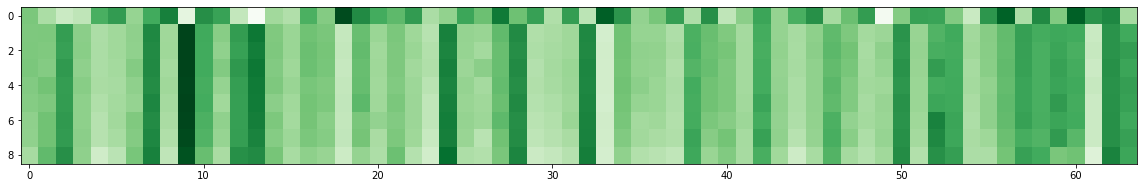

In [ ]:
plt.figure(figsize=(20,5))
plt.imshow(model_pos_trained.positional_emb.detach().numpy().squeeze(), cmap='Greens')
plt.show()

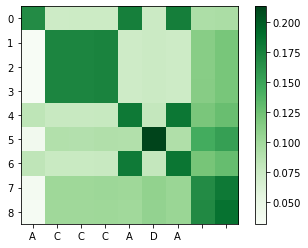

In [ ]:
# self attention
plt.imshow(self_att.squeeze(0).detach().numpy(), cmap='Greens')
plt.colorbar()
plt.xticks(range(9), list(sample) + [' ' for i in range(len(sample),9)])
plt.show()

In [ ]:
logits.argmax(-1)

tensor([[2]])

# 4. Translate numbers (complete transformer 🎉)

In [ ]:
!git checkout chore/add-model-bin

Already on 'chore/add-model-bin'
Your branch is up to date with 'origin/chore/add-model-bin'.


## 4.1 Task ( translate numbers )

The translation task is translate numbers.

| input-text | output-text |
| ------ | ------ |
| uno       |    1    |
| dos       |    2    |
| ...       |    ...    |
| quinientos mil       |    500000    |
| one       |    1    |
| two       |    2    |
| ...       |    ...    |
| five hundred thousand       |    500000    |

## 4.2 Load trained model (60Mb)... 

In [ ]:
from transformer_uth.original.raw_inference import _get_vocab_transform, _get_text_transform, _load_model, translate

from transformer_uth.original.raw_pytorch_transformer import (
    MODEL_NAME,
    PATH_TRANSFORMER_MODEL
)


vocab_transform, src_vocab, tgt_vocab = _get_vocab_transform()
text_transform = _get_text_transform(vocab_transform)

path_transformer = PATH_TRANSFORMER_MODEL / MODEL_NAME
model = _load_model(path_transformer, src_vocab, tgt_vocab)

In [ ]:
model

Seq2SeqTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_feature

In [ ]:
# n_params 
sum(p.numel() for p in model.parameters())

12655118

In [ ]:
print("Model parameters: ")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel():,}")

Model parameters: 
transformer.encoder.layers.0.self_attn.in_proj_weight: 786,432
transformer.encoder.layers.0.self_attn.in_proj_bias: 1,536
transformer.encoder.layers.0.self_attn.out_proj.weight: 262,144
transformer.encoder.layers.0.self_attn.out_proj.bias: 512
transformer.encoder.layers.0.linear1.weight: 262,144
transformer.encoder.layers.0.linear1.bias: 512
transformer.encoder.layers.0.linear2.weight: 262,144
transformer.encoder.layers.0.linear2.bias: 512
transformer.encoder.layers.0.norm1.weight: 512
transformer.encoder.layers.0.norm1.bias: 512
transformer.encoder.layers.0.norm2.weight: 512
transformer.encoder.layers.0.norm2.bias: 512
transformer.encoder.layers.1.self_attn.in_proj_weight: 786,432
transformer.encoder.layers.1.self_attn.in_proj_bias: 1,536
transformer.encoder.layers.1.self_attn.out_proj.weight: 262,144
transformer.encoder.layers.1.self_attn.out_proj.bias: 512
transformer.encoder.layers.1.linear1.weight: 262,144
transformer.encoder.layers.1.linear1.bias: 512
transform

In [ ]:
src_char2tk_id = {v:k for k,v in src_vocab.items()}

## 4.3 Visualize attentions 🦄 ...

In [ ]:
from num2words import num2words

import random 

i = random.randint(1000,2000)
word = num2words(i, lang="es")

In [ ]:
text = "ciento dos"
#text = "dos"

#text = "seiscientos cuarenta y cinco mil ochocientos tres"
text = "sescients cuareta y cincml ochocients tress"
#text = word
#text = "cuarent y two"
text = "hola buenas dias"
#text = "hola uenas dias"
#text = "1 millon cuatrocientos cincuenta y cinco mil"
#text = "🤷 y dos"

output_text, enc_at, dec_at = translate(
        model, text, text_transform, vocab_transform
)

In [ ]:
output_text

' 8 0 0 6 '

In [ ]:
tks = text_transform['text'](text).view(-1, 1)

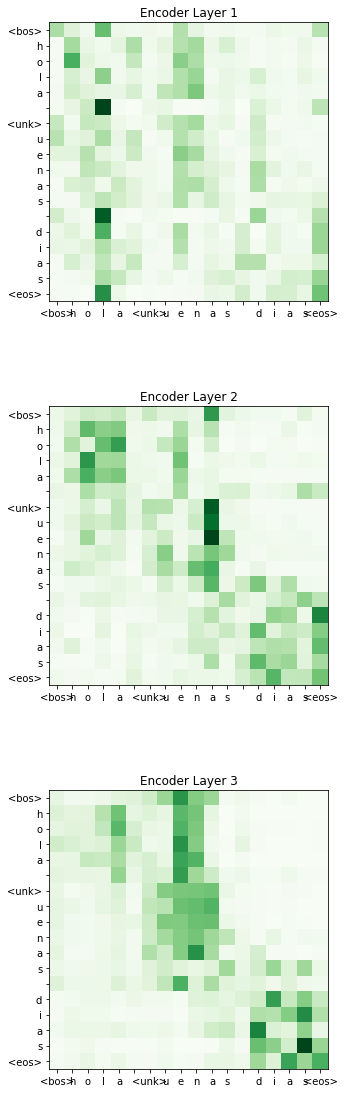

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(5,20))

for i,ax in enumerate(axs):
  ax.imshow(enc_at[i].detach().numpy().squeeze(), cmap='Greens')
  ax.set_xticks(range(len(tks)))
  ax.set_xticklabels([src_char2tk_id[tk_id] for tk_id in tks.view(-1).tolist()])
  ax.set_yticks(range(len(tks)))
  ax.set_yticklabels([src_char2tk_id[tk_id] for tk_id in tks.view(-1).tolist()])
  ax.set_title(f'Encoder Layer {i+1}')

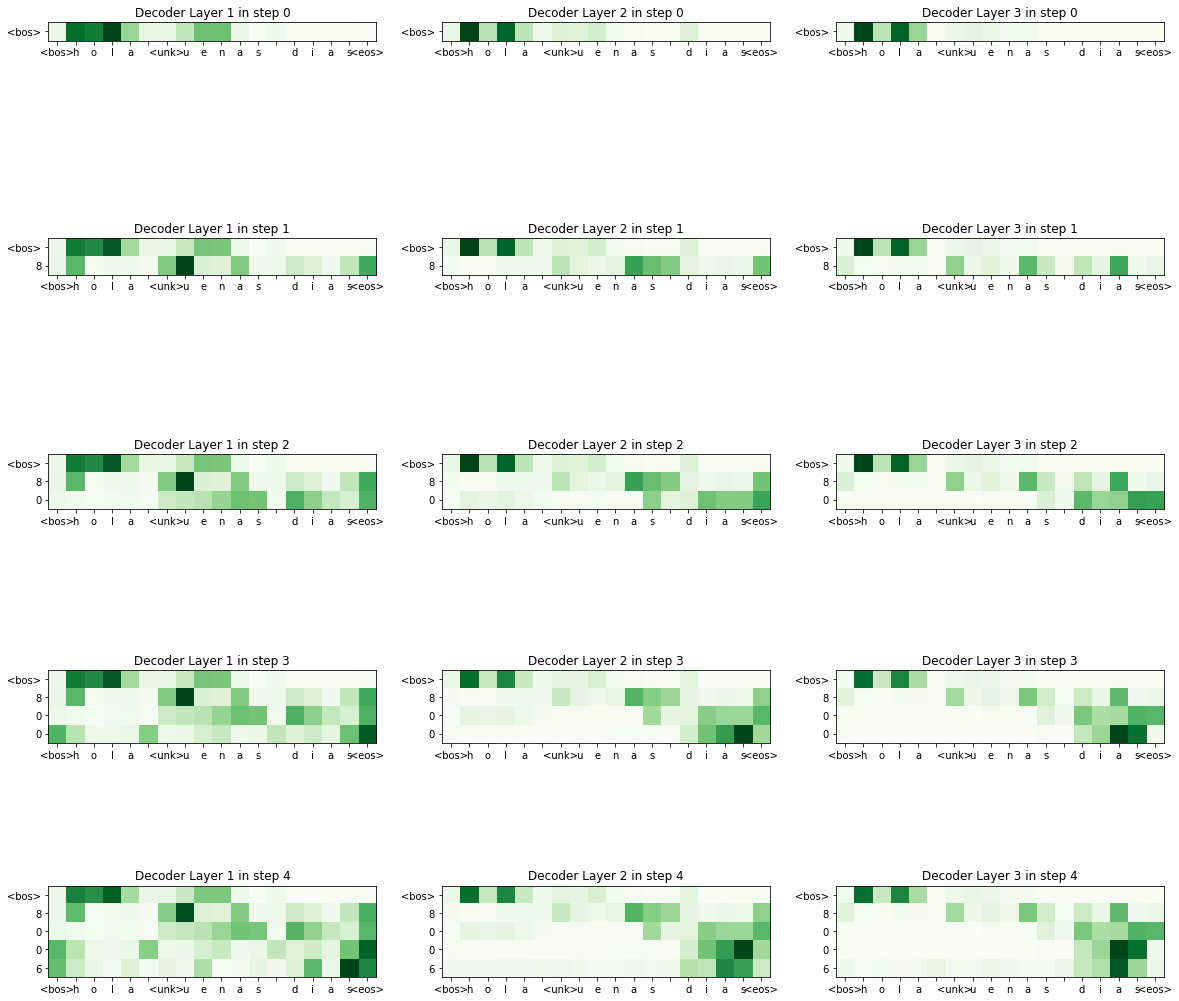

In [ ]:
num_steps = len(dec_at)
num_layers = 3

fig, axs = plt.subplots(num_steps, num_layers, figsize=(20,20))

for i in range(num_steps):
  for j in range(num_layers):
    matrix_dec = dec_at[i][j].squeeze(0).detach().numpy()
    num_output = matrix_dec.shape[0]
    ax = axs[i][j]
    ax.imshow(matrix_dec, cmap='Greens')
    ax.set_xticks(range(len(tks)))
    ax.set_xticklabels([src_char2tk_id[tk_id] for tk_id in tks.view(-1).tolist()])
    ax.set_yticks(range(num_output))
    ax.set_yticklabels(['<bos>']+ list(output_text.replace(' ','')[:num_output-1]))
    
    ax.set_title(f'Decoder Layer {j+1} in step {i}')
